In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Data

In [2]:
df = pd.read_csv("singindex_large_social_data.csv", index_col=0)
metadf = pd.read_csv("singindex_large_social_metadata.csv")

In [3]:
df.describe()

,"Adjusted net enrollment rate, primary (% of primary school age children)","Adjusted net enrollment rate, primary, female (% of primary school age children)","Adjusted net enrollment rate, primary, male (% of primary school age children)",Adolescents out of school (% of lower secondary school age),"Adolescents out of school, female (% of female lower secondary school age)","Adolescents out of school, male (% of male lower secondary school age)","Agriculture, forestry, and fishing, value added (annual % growth)",Children out of school (% of primary school age),"Children out of school, female (% of female primary school age)","Children out of school, male (% of male primary school age)",...,"Unemployment, total (% of total labor force) (national estimate)","Unemployment, youth female (% of female labor force ages 15-24) (modeled ILO estimate)","Unemployment, youth male (% of male labor force ages 15-24) (modeled ILO estimate)","Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate)","Vulnerable employment, female (% of female employment) (modeled ILO estimate)","Vulnerable employment, male (% of male employment) (modeled ILO estimate)","Vulnerable employment, total (% of total employment) (modeled ILO estimate)","Wage and salaried workers, female (% of female employment) (modeled ILO estimate)","Wage and salaried workers, male (% of male employment) (modeled ILO estimate)","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)"
count,11.000000,10.000000,9.000000,22.000000,22.000000,22.000000,50.000000,49.000000,49.000000,49.000000,...,19.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,90.156370,89.479082,90.997292,19.416559,20.519170,18.372859,2.708496,16.208859,19.862198,12.727677,...,5.695511,14.912449,13.648104,13.941247,49.814878,49.355856,49.536092,48.936198,47.240744,47.903971
std,0.319998,0.203033,0.447852,3.709608,4.773528,2.710687,1.253649,6.021988,8.294690,3.880770,...,0.410764,1.679987,1.098001,1.222688,3.357797,3.202454,3.261585,3.258097,3.212051,3.224637
min,89.738960,89.127900,90.240070,15.344200,15.358350,15.330970,0.341153,8.018430,8.932310,7.142610,...,4.837422,10.993634,10.843149,10.848933,43.930847,43.649915,43.761650,45.009877,43.393486,44.029202
25%,89.823760,89.371533,90.745770,16.571062,16.429500,16.518067,1.875913,9.053080,10.360450,8.459990,...,5.435467,14.354621,12.991314,13.352841,46.683403,46.398663,46.512749,45.997824,44.387945,45.025302
50%,90.287560,89.508525,91.152540,18.460005,19.498345,17.486220,2.660671,17.459820,21.408260,13.547640,...,5.631747,15.116705,13.925072,14.368463,50.812918,50.330100,50.522187,47.964769,46.273905,46.940797
75%,90.451455,89.616798,91.404090,21.538603,23.290125,19.881413,3.544419,20.831020,27.161350,14.785260,...,5.922826,16.010696,14.548057,14.873097,52.846313,52.267022,52.520998,51.993374,50.264899,50.934801
max,90.513600,89.763950,91.463530,26.133310,28.997370,23.407221,5.331019,28.315510,35.758518,21.195221,...,6.404584,17.139938,14.954903,15.451333,53.840581,52.914234,53.269819,54.622053,52.815285,53.511730


## Pre-processing

### Build index components

In [4]:
index_comps, metadf_rows = [], []
for (k, j) in enumerate(metadf["indicator"]):
    
    if metadf["improvement"].iloc[k] != 0:
        
        if (len(df[j].dropna()) > 2):
        
            # base value
            med_value = df[j].median()

            if np.isnan(med_value) == 0:

                # indicator and direction
                indicator = (df[[j]]/med_value) ** metadf["improvement"].iloc[k]

                if k==0:
                    df_index = indicator.copy()
                else:
                    df_index = pd.concat([df_index, indicator.copy()], axis=1)
                
                index_comps += [j]
                metadf_rows += [k]
                
df_index.index = df.index.copy()

### Export info

In [5]:
df[index_comps].to_csv("singindex_large_social_raw_components.csv")
df_index.to_csv("singindex_large_social_base_components.csv")
metadf.iloc[metadf_rows].to_csv("singindex_large_social_novel_metadata.csv")

## Interpolation, Build Index, and Extrapolation

In [6]:
from scipy import interpolate

In [20]:
# interpolation
df_interp_index = df_index.interpolate(method="linear")

<AxesSubplot:xlabel='Date'>

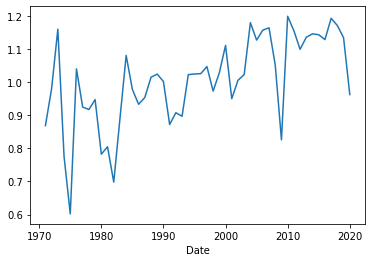

In [21]:
# build index
singindex_historic = df_interp_index.mean(axis=1)
singindex_historic.plot()

In [22]:
# model index to extrapolate (exclude 2020 data)
s_model = interpolate.interp1d(singindex_historic.index[-20:-1], singindex_historic.values[-20:-1], fill_value="extrapolate")

<AxesSubplot:>

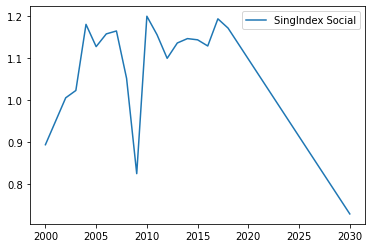

In [23]:
singindex = pd.DataFrame({"SingIndex Social": s_model(range(2000, 2031))},
            index = list(range(2000, 2031)))
singindex.plot()

In [24]:
singindex[-15:]

,SingIndex Social
2016,1.128508
2017,1.192904
2018,1.170950
2019,1.134211
2020,1.097471
2021,1.060732
2022,1.023993
2023,0.987253
2024,0.950514
2025,0.913775


### Export

In [25]:
df_interp_index.to_csv("singindex_large_social_base_components_interpolate.csv")
singindex_historic.to_csv("singindex_large_social_avg_interpolate.csv")
singindex.to_csv("singindex_large_social_avg_extrapolate_2000_2030.csv")